# **Class Imbalance  in MNIST dataset**

The network was trained using the criteria specified in the paper **"A Systematic Study of the Class Imbalance Problem in Convolutional Neural Networks"** by Mateusz Buda, Atsuto Maki, and Maciej A. Mazurowski, for a total of 10,000 iterations. The optimization was performed with stochastic gradient descent (SGD) and a momentum value of `μ = 0.9`. The learning rate decay followed the policy `η_t = η_0 * (1 + γ * t)^(-α)`, where the base learning rate `η_0 = 0.01`, with decay parameters `γ = 0.0001` and `α = 0.75`, and `t` is the current iteration. A `batch size of 64` and a weight decay value of `λ = 0.0005` were used. Network weights were initialized with a uniform distribution with Xavier variance, while biases were initialized to zero.

 `Imbalance ratio = 1000`

 `Number of minority classes = 8`

## The obtained reults from one experiment:

* **Baseline:**
   __  ROC AUC = 0.9783  ____  Accuracy: 0.6558    

* **Oversampling:**
   __  ROC AUC = 0.9652  ____  Accuracy: 0.7416  

#  Define the LeNet-5 Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(50 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

        self._initialize_weights()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 50 * 4 * 4)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        # Xavier Initialization for weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)


#  Define the Learning Rate Scheduler


In [2]:
class CustomLRScheduler:
    def __init__(self, optimizer, base_lr=0.01, gamma=0.0001, alpha=0.75):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.gamma = gamma
        self.alpha = alpha
        self.iteration = 0

    def step(self):
        self.iteration += 1
        lr = self.base_lr * (1 + self.gamma * self.iteration) ** (-self.alpha)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr


# Set Up Data Loaders   (baseline)

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

# Define transform for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Generate a list of indices for the dataset
ind = np.arange(len(mnist))
# Shuffle the indices
np.random.shuffle(ind)
# Create a new Subset with the shuffled indices
mnist0 = Subset(mnist, ind)
mnist0.targets = mnist.targets

# Filter indices for each class
def filter_class_indices(dataset, class_label, num_samples):
    indices = [i for i, target in enumerate(dataset.targets) if target == class_label]
    # Shuffle indices
    np.random.shuffle(indices)
    return indices[:num_samples]

# Define the number of samples per class
# imbalance ratio = 1000
# number of minority classes = 8
num_samples_per_class = {
    0: 5,
    1: 5,
    2: 5000,
    3: 5,
    4: 5,
    5: 5,
    6: 5,
    7: 5000,
    8: 5,
    9: 5
}

# Create lists of indices for each class
indices = []
for class_label, num_samples in num_samples_per_class.items():
    class_indices = filter_class_indices(mnist, class_label, num_samples)
    indices.extend(class_indices)

# Create the subset of the MNIST dataset with the specified samples
subset = Subset(mnist, indices)
# Create a DataLoader for the modified dataset
batch_size = 64  # Set your batch size
trainloader = DataLoader(subset, batch_size=batch_size, shuffle=True)



In [28]:
# Checking that the settings are correct.

from collections import defaultdict

class_counts = defaultdict(int)

# Iterate over the data in the DataLoader
for images, labels in trainloader:
    # labels is a tensor of class indices
    for label in labels:
        class_counts[label.item()] += 1

# Print out the number of samples for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")

Class 7: 5000 samples
Class 2: 5000 samples
Class 3: 5 samples
Class 0: 5 samples
Class 8: 5 samples
Class 5: 5 samples
Class 9: 5 samples
Class 1: 5 samples
Class 4: 5 samples
Class 6: 5 samples


# Define Training and Evaluation Functions

In [5]:
import torch.optim as optim

def train(model, trainloader, criterion, optimizer, scheduler, device, num_iterations):
    model.train()
    running_loss = 0.0
    iteration_count = 0

    for epoch in range(num_iterations):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * images.size(0)
            iteration_count += 1

            # Print the loss and accuracy every 1000 iterations
            if iteration_count % 1000 == 0:
                train_loss = running_loss / (iteration_count * 64)  # 64 is the batch size
                accuracy = evaluate(model, testloader, device)
                print(f'Iteration {iteration_count}/{num_iterations}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}')

            if iteration_count >= num_iterations:
                break
        if iteration_count >= num_iterations:
            break

    epoch_loss = running_loss / (iteration_count * 64)  # 64 is the batch size
    return epoch_loss


def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


#Training the Model (baseline)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)

# Define the optimizer with weight decay
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = CustomLRScheduler(optimizer, base_lr=0.01, gamma=0.0001, alpha=0.75)

criterion = nn.CrossEntropyLoss()
num_iterations = 10000

train_loss = train(model, trainloader, criterion, optimizer, scheduler, device, num_iterations)


Iteration 1000/10000, Loss: 0.0480, Accuracy: 0.3254
Iteration 2000/10000, Loss: 0.0282, Accuracy: 0.5652
Iteration 3000/10000, Loss: 0.0196, Accuracy: 0.6095
Iteration 4000/10000, Loss: 0.0149, Accuracy: 0.6128
Iteration 5000/10000, Loss: 0.0121, Accuracy: 0.6274
Iteration 6000/10000, Loss: 0.0102, Accuracy: 0.6654
Iteration 7000/10000, Loss: 0.0088, Accuracy: 0.6693
Iteration 8000/10000, Loss: 0.0078, Accuracy: 0.6371
Iteration 9000/10000, Loss: 0.0070, Accuracy: 0.6462
Iteration 10000/10000, Loss: 0.0063, Accuracy: 0.6558


# Compute ROC Curve and AUC (baseline)

In [18]:
def predict_scores(model, testloader, device):
    model.eval()
    outputs = []
    test_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs.append(model(images))
            test_labels.append(labels)


    #accuracy = correct / total
    return outputs , test_labels

y_score , test_labels = predict_scores(model, testloader, device)

# Concatenate tensors along the 0th dimension (default)
y_score = torch.cat(y_score)
test_labels = torch.cat(test_labels)
print(y_score.shape)
print(test_labels.shape)

torch.Size([10000, 10])
torch.Size([10000])


In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Binarize the output labels for the multi-class case
y_test_bin = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_test_bin.shape[1]

# Compute ROC AUC for each class
roc_auc = {}
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr, tpr)

# Compute the average AUC
average_auc = np.mean(list(roc_auc.values()))

print(f'Average AUC: {average_auc:.4f}')

Average AUC: 0.9783


# Plot ROC Curves

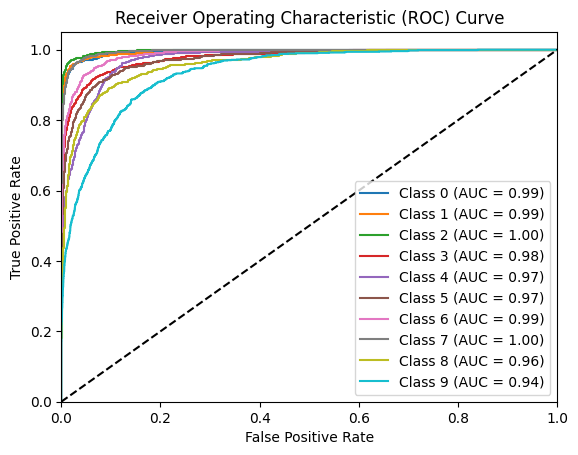

In [16]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Set Up Data Loaders   (oversampling)

In [26]:
num_samples_per_class = {
    0: 5,
    1: 5,
    2: 5000,
    3: 5,
    4: 5,
    5: 5,
    6: 5,
    7: 5000,
    8: 5,
    9: 5
}

# Get the maximum number of samples across all classes
max_samples = max(num_samples_per_class.values())

# Create lists of indices for each class
indices = []
for class_label, num_samples in num_samples_per_class.items():
    # Get the indices for the current class
    class_indices = filter_class_indices(mnist, class_label, num_samples)

    # Determine how many times to repeat the indices to match max_samples
    repeat_times = (max_samples + len(class_indices) - 1) // len(class_indices)  # Calculate ceiling of max_samples / len(class_indices)

    # Repeat the class indices and truncate to the required number of samples
    balanced_class_indices = (class_indices * repeat_times)[:max_samples]

    # Extend the indices list with the balanced indices
    indices.extend(balanced_class_indices)

print(len(indices))


# Create the subset of the MNIST dataset with the specified samples
subset = Subset(mnist, indices)
# Create a DataLoader for the modified dataset
batch_size = 64  # Set your batch size
trainloader_oversampling = DataLoader(subset, batch_size=batch_size, shuffle=True)

50000


# Train model  (oversampling)

In [29]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)

# Define the optimizer with weight decay
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = CustomLRScheduler(optimizer, base_lr=0.01, gamma=0.0001, alpha=0.75)

criterion = nn.CrossEntropyLoss()
num_iterations = 10000

train_loss = train(model, trainloader_oversampling, criterion, optimizer, scheduler, device, num_iterations)

Iteration 1000/10000, Loss: 0.0442, Accuracy: 0.7156
Iteration 2000/10000, Loss: 0.0241, Accuracy: 0.7203
Iteration 3000/10000, Loss: 0.0171, Accuracy: 0.7178
Iteration 4000/10000, Loss: 0.0134, Accuracy: 0.7174
Iteration 5000/10000, Loss: 0.0111, Accuracy: 0.6964
Iteration 6000/10000, Loss: 0.0096, Accuracy: 0.7269
Iteration 7000/10000, Loss: 0.0084, Accuracy: 0.7215
Iteration 8000/10000, Loss: 0.0076, Accuracy: 0.7238
Iteration 9000/10000, Loss: 0.0069, Accuracy: 0.7131
Iteration 10000/10000, Loss: 0.0063, Accuracy: 0.7416


# Compute ROC Curve and AUC (oversampling)

In [31]:
y_score , test_labels = predict_scores(model, testloader, device)

# Concatenate tensors along the 0th dimension (default)
y_score = torch.cat(y_score)
test_labels = torch.cat(test_labels)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Binarize the output labels for the multi-class case
y_test_bin = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_test_bin.shape[1]

# Compute ROC AUC for each class
roc_auc = {}
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr, tpr)

# Compute the average AUC
average_auc = np.mean(list(roc_auc.values()))

print(f'Average AUC: {average_auc:.4f}')



Average AUC: 0.9652
